# FASHION-MNIST dataset  -- Classification using neural network with fully connected layers

In [1]:
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data Loading, Preprocessing and Exploration

### Dataset Loading and Splitting

In [3]:
import os
import urllib.request
from sh import gunzip
import numpy as np
from sklearn.model_selection import train_test_split
from mlxtend.data import loadlocal_mnist

In [4]:
from read_fashion_mnist import FashionMnistLoader
## Windows users:
#from read_fashion_mnist_win import FashionMnistLoader

In [5]:
data_loader = FashionMnistLoader().get_all_data()

X_train_dev, X_test, y_train_dev, y_test = data_loader.standard_split()
X_train_dev.shape, X_test.shape, len(y_train_dev), len(y_test)

((60000, 784), (10000, 784), 60000, 10000)

In [6]:
X_train, X_dev, y_train, y_dev = data_loader.train_split(1/6)
X_train.shape, X_dev.shape, len(y_train), len(y_dev)

((50000, 784), (10000, 784), 50000, 10000)

### Minibatches

We are going to train using minibatches. There is a convinient class `torch.utils.data.Dataset` that helps do it. One hase to implement

- `__len__` so that `len(dataset)` returns the size of the dataset.
- `__getitem__` that returns `i`th sample.

In [7]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class FashionMnist(Dataset):
    
    def __init__(self, X, y):
        self.data = torch.from_numpy(X).float()
        self.target = torch.from_numpy(y).long()
        
    def __len__(self):
        return len(self.target)
        
    def __getitem__(self, index):
        img, tar = self.data[index], self.target[index]
        img = (img/255).reshape(-1, 1, 28, 28).squeeze()
        return img, tar
    
train_dataset = FashionMnist(X_train, y_train)
dev_dataset = FashionMnist(X_dev, y_dev)

In [8]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
num_classes = len(classes)

In [9]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=True)

### Let's look a bit at data

In [10]:
## Read first batch (16 images)
dataiter = iter(train_loader)
images_pt, labels = dataiter.next()
images_pt.shape

torch.Size([16, 28, 28])

#### What is that

`[batch size, number of channels, y, x]`

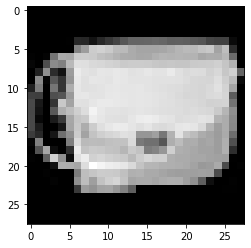

'Bag'

In [11]:
## Transform it to numpy and get the first one
images = images_pt.numpy()
plt.imshow(np.squeeze(images[0]), cmap='gray')
plt.show()

## Print its class name
classes[labels[0]]

Images are in the shape `[batch size, number of channels, y, x]` so we need to flatten them:

In [12]:
images_pt.reshape(images_pt.size(0), -1).shape

torch.Size([16, 784])

Let's look a bit more on images.

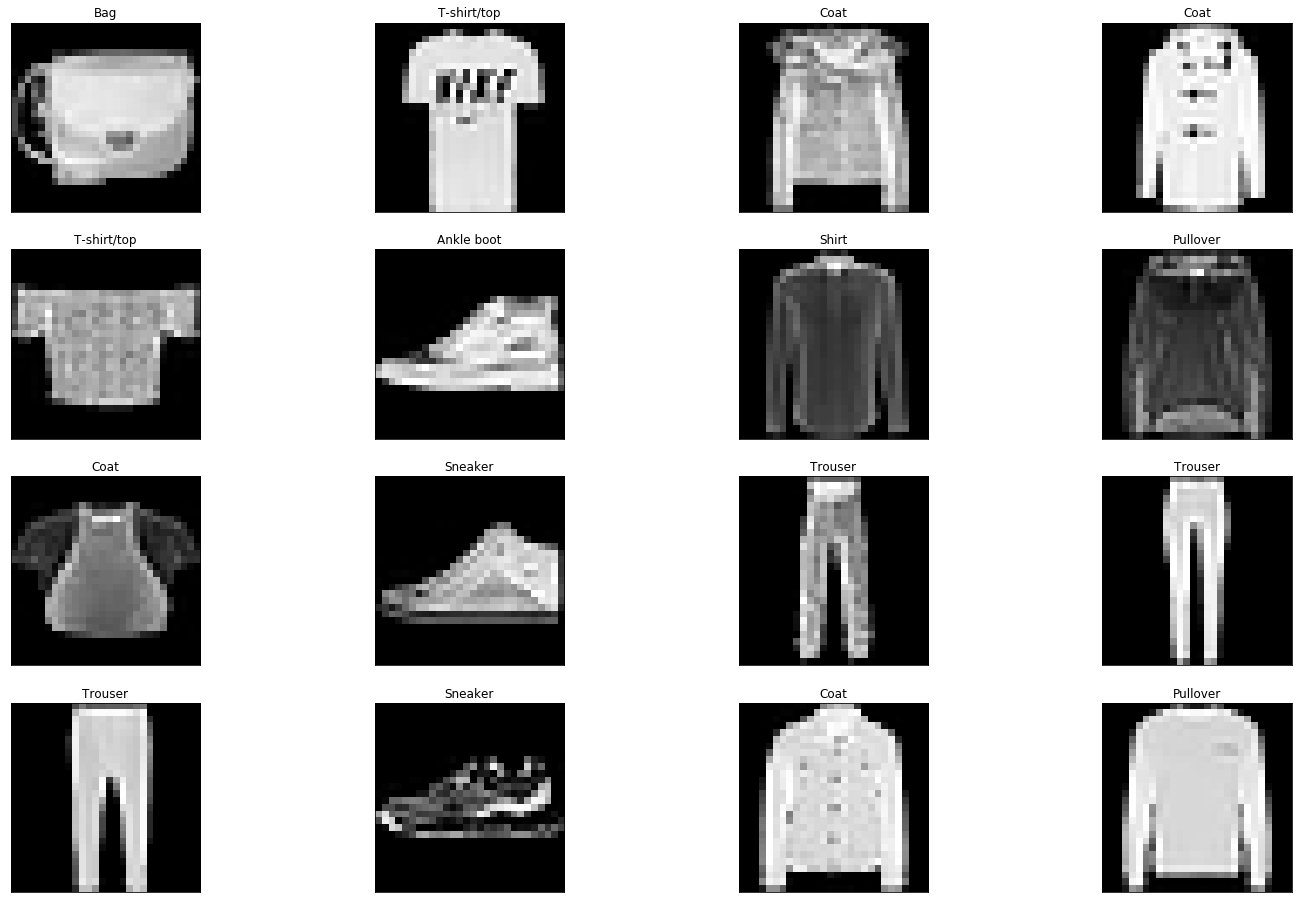

In [13]:
fig = plt.figure(figsize=(25, 16))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(4, batch_size/4, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

In [14]:
idx = np.random.choice(batch_size)
img = np.squeeze(images[idx])

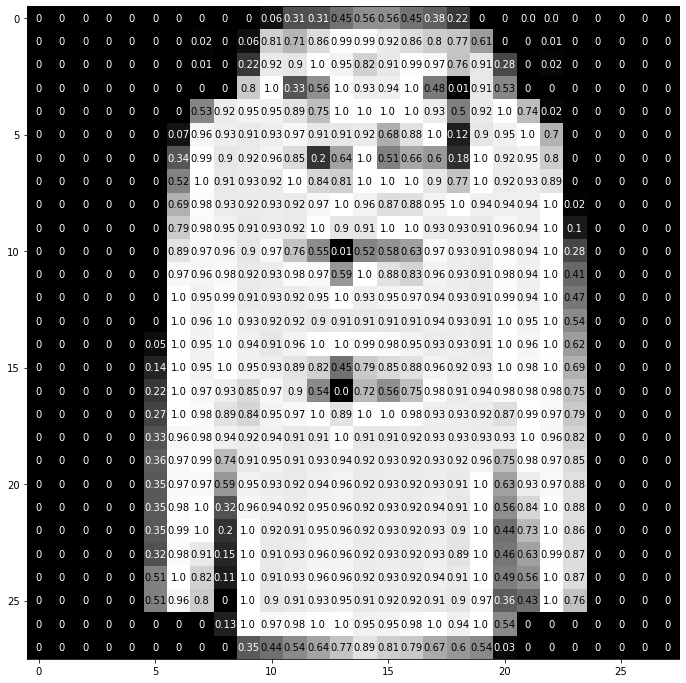

In [15]:
# display the pixel values in that image
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y], 2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

## Let's define Neural Network with pytorch

In [16]:
from torch import nn
from torch import optim
import torch.nn.functional as F

### Neural Network

The neural network is a structure that joins together perceptrons. Here we can see an example of it.

![Simple Neuron 2](docs/pngs/nn.png)


### Defining a Neural Network
Sometimes you will want to specify models that are more complex than a sequence of existing Modules; for these cases you can define your own Modules by subclassing ```nn.Module``` and defining a ```forward``` which receives input Tensors and produces output Tensors using other modules or other autograd operations on Tensors.

In this example we implement our two-layer network as a custom Module subclass:

In [17]:
input_dim = 28 * 28

class LinearNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x
    
model = LinearNN()


The learnable parameters of a model are returned by ```model.parameters()``` and ```model.named_parameters()```

In [18]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.0345,  0.0065, -0.0287,  ...,  0.0076, -0.0247, -0.0111],
         [ 0.0036,  0.0175, -0.0083,  ...,  0.0116, -0.0324, -0.0182],
         [-0.0192, -0.0074,  0.0185,  ...,  0.0326,  0.0275,  0.0297],
         ...,
         [ 0.0128, -0.0269, -0.0303,  ..., -0.0306, -0.0288,  0.0085],
         [ 0.0165, -0.0154,  0.0345,  ...,  0.0100, -0.0342, -0.0263],
         [ 0.0355, -0.0192,  0.0203,  ..., -0.0351, -0.0176,  0.0068]],
        requires_grad=True), Parameter containing:
 tensor([ 0.0207,  0.0315, -0.0313, -0.0077, -0.0262, -0.0323, -0.0114,  0.0051,
         -0.0317, -0.0071,  0.0212,  0.0099,  0.0099, -0.0227, -0.0259,  0.0035,
          0.0283, -0.0022,  0.0054,  0.0072, -0.0014,  0.0078, -0.0133, -0.0146,
         -0.0030,  0.0115, -0.0154,  0.0181, -0.0251, -0.0330, -0.0255,  0.0153,
         -0.0184, -0.0258,  0.0124, -0.0261, -0.0320, -0.0175, -0.0140,  0.0003,
          0.0335, -0.0291, -0.0284,  0.0061,  0.0175, -0.0193, -0.0351,  0.0261,

In [19]:
print({name: (val.shape,val.numel()) for name, val in model.named_parameters()})

{'fc1.weight': (torch.Size([64, 784]), 50176), 'fc1.bias': (torch.Size([64]), 64), 'fc2.weight': (torch.Size([10, 64]), 640), 'fc2.bias': (torch.Size([10]), 10)}


In [20]:
# Compute the number of parameters of the model and implement a method to compute it.
def compute_parameter_number(model):
    ### your code goes here
    num_param = sum([val.numel() for _, val in model.named_parameters()])
    return num_param

compute_parameter_number(model)

50890

### Defining the loss criteria and the optimizer

Let us list the most important loss criteria functions.

#### MSE

This is the one you vary likely to know. If $y_i$ are the real values and $\hat{y}_i$ are predicted, then

$$MSE(y, \hat{y}) = \frac{1}{N}\sum_i^N (y_i - \hat{y}_i)^2.$$

#### Binary cross entropy

This one is used whan we have binary classification problem. Here $y_i \in \{0, 1\}$ and $\hat{y}_i$ is predicted probablity that the output belongs to target class. Then __binary cross entropy__ is definied by:

$$bce(y, \hat{y}) = -\sum_{i} \big(y_i \log(\hat{y}_i) + (1- y_i) \log(1-\hat{y}_i)\big).$$

#### Cross entropy

This is used when we have more than one class. Let assume that we have $j=1,\ldots, K$ classes and $y_{i,j}$ is one-hot-encodig of the outcome. That is $y_{i,j}$ is one if outcome is class $j$ and 0 otherwise. And let 
$\hat{y}_{i, j}$ be the predicted probablity that the sample $i$ belongs to class $j$. Then

$$bce(y, \hat{y}) = -\sum_{i} \sum_j y_{i, j} \log(\hat{y}_{i, j}).$$

In [21]:
criterion = nn.CrossEntropyLoss()

### Let's see how it performs before training
After we have created neural network its weights are initialized randomly.

In [22]:
batch_size = 16

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## In test set we put all dataset.
test_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=len(dev_dataset), shuffle=True)

In [23]:
len(dev_dataset)

10000

In [24]:
correct = 0
total = 0

for images, labels in test_loader:

    outputs = model(images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum()

accuracy = 100.0 * correct.item() / total

print(accuracy,"%")

10.92 %


## Let's train it

After we have created neural network its weights are initialized randomly. Then we need to train the network. We do this by repeating the following steps.

1. Forward pass
2. Calculate loss
3. Backpropagate erros: calculate gradients
4. Update weights

In [25]:
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [26]:
def train(n_epochs):
    
    loss_over_time = [] # to track the loss as the network trains
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            inputs, labels = data

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            outputs = model(inputs)

            # calculate the loss
            loss = criterion(outputs, labels)

            # backward pass to calculate the parameter gradients
            loss.backward()

            # update the parameters
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to running_loss, we use .item()
            running_loss += loss.item()
            
            if batch_i % 1000 == 999:    # print every 1000 batches
                avg_loss = running_loss/1000
                # record and print the avg loss over the 1000 batches
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, avg_loss))
                running_loss = 0.0

    print('Finished Training')
    return loss_over_time


In [27]:
n_epochs = 2 # start small to see if your model works, initially
model.train() # put model in train mode (important with, for example, dropouts, batch normalizations...)

training_loss = train(n_epochs) # call train and record the loss over time

Epoch: 1, Batch: 1000, Avg. Loss: 1.1390550715625287
Epoch: 1, Batch: 2000, Avg. Loss: 0.6795856177955866
Epoch: 1, Batch: 3000, Avg. Loss: 0.5951115951836109
Epoch: 2, Batch: 1000, Avg. Loss: 0.5216082922816276
Epoch: 2, Batch: 2000, Avg. Loss: 0.5153238933086395
Epoch: 2, Batch: 3000, Avg. Loss: 0.5014053465425968
Finished Training


In [28]:
# initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))

# set the module to evaluation mode
model.eval()

# get the input images and their corresponding labels
dataiter = iter(test_loader)
inputs, labels = dataiter.next()

# forward pass to get outputs
outputs = model(inputs)

# calculate the loss
test_loss = criterion(outputs, labels)

# get the predicted class from the maximum value in the output-list of class scores
_, predicted = torch.max(outputs.data, 1)

# compare predictions to true label
# this creates a `correct` Tensor that holds the number of correctly classified images in a batch
correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))

# calculate test accuracy for *each* object class
# we get the scalar value of correct items for a class, by calling `correct[i].item()`
for i in range(len(inputs)):
    label = labels.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1

print('Test Loss: {:.6f}\n'.format(test_loss.detach().numpy()))

Test Loss: 0.490642



In [29]:
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Accuracy of T-shirt/top: 83% (865/1034)
Test Accuracy of Trouser: 95% (959/1005)
Test Accuracy of Pullover: 64% (650/1001)
Test Accuracy of Dress: 85% (839/979)
Test Accuracy of  Coat: 89% (855/959)
Test Accuracy of Sandal: 89% (902/1004)
Test Accuracy of Shirt: 41% (417/1007)
Test Accuracy of Sneaker: 93% (943/1009)
Test Accuracy of   Bag: 93% (960/1027)
Test Accuracy of Ankle boot: 91% (888/975)

Test Accuracy (Overall): 82% (8278/10000)


## Some more insights

Let's look at 16 images.

In [30]:
insight_size = 16
inputs_sample = inputs[:insight_size].numpy()
labels_sample = labels[:insight_size]
outputs_sample = outputs[:insight_size]
predicted_sample = predicted[:insight_size].numpy()

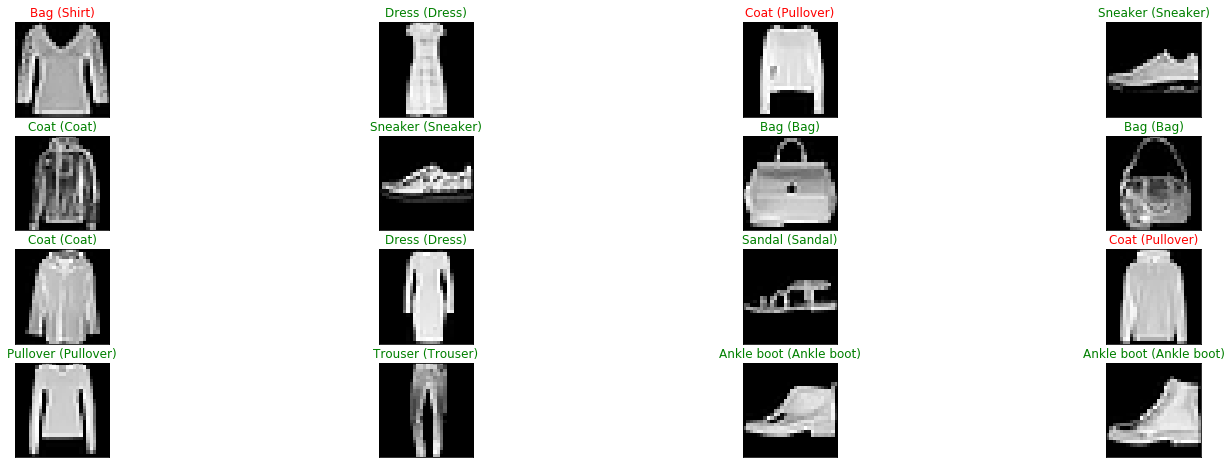

In [31]:
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 8))
for idx in np.arange(insight_size):
    ax = fig.add_subplot(4, insight_size/4, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(inputs_sample[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[predicted_sample[idx]], classes[labels[idx]]),
                 color=("green" if predicted_sample[idx]==labels[idx] else "red"))

In [32]:
from sklearn.metrics import confusion_matrix

batch_size=10000
test_loader3 = torch.utils.data.DataLoader(dev_dataset, batch_size=10000, shuffle=True)
dataiter3 = iter(test_loader3)
images3, labels3 = dataiter3.next()
outputs = model(images3)
array  = confusion_matrix(labels3, np.squeeze(outputs.data.max(1, keepdim=True)[1].numpy()))

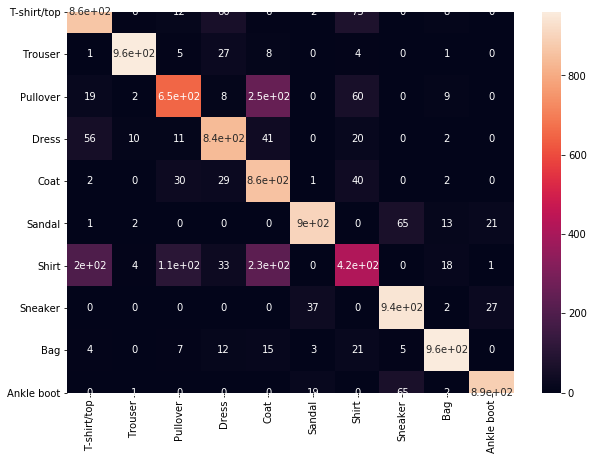

In [33]:
import pandas as pd
import seaborn as sn

df_cm = pd.DataFrame(array, index = [i for i in classes],
                  columns = [i for i in classes ])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

## Explore different architectures and configurations

### Exercise 1
Create nn.Module with different number of layers and sizes and 
let's see who gets higher accuracy :)

In [34]:
## your code goes here

## Try diffent optimizers

#### Exercise 2
Train the model LinearNN() and your custom one using 4 different optimizers and compare the evolution of
the loss over the iterations of the training procedure. you can reuse the model definition as well as the
training function, which outputs the training loss at the different time steps.
Look for the effect of the learnign rate

In [35]:
## your code goes here

In [ ]:
# This code can help you generate a starting image
plt.figure
iter_num = np.arange(0,6000,1000)
plt.plot(iter_num, training_loss_adam, label='Adam')
plt.plot(iter_num, training_loss_rms, label='RMSProp')
plt.plot(iter_num, training_loss_sdg, label='SGD')
plt.legend()
plt.xlabel('loss')
plt.xlabel('iterations')
plt.show()